# Predizione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:
- **id**: id univoco dell'acquirente.
- **Gender**: sesso dell'acquirente.
- **Age**: età dell'acquirente.
- **Driving_License**: 1 se l'utente ha la patente di guida, 0 altrimenti.
- **Region_Code**: codice univoco della regione dell'acquirente.
- **Previously_Insured**: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
- **Vehicle_Age**: età del veicolo
- **Vehicle_Damage**: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
- **Annual_Premium**: la cifra che l'utente deve pagare come premio durante l'anno.
- **Policy_Sales_Channel**: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
- **Vintage**: numero di giorni dalla quale l'utente è cliente dell'azienda.
- **Response**: 1 se l'acquirente ha risposto positivametne alla proposta di vendità, 0 altrimenti.

L'obiettivo del modello è prevedere il valore di **Response** in base al valore delle altre proprietà

## Dipendenze

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.feature_selection import mutual_info_classif
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from datetime import datetime

In [2]:
pd.set_option('display.max_rows', 300)

plt.rcParams["figure.figsize"] = (60,15)
plt.rcParams['font.size'] = 16

## Scarichiamo il Dataset
Il dataset è disponibile su Kaggle a [questo indirizzo](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction). Per scaricarlo usiamo direttamente le API di Kaggle. Creiamo il file json di autenticazione con il nostro nome utente Kaggle e la chiave.

In [3]:
!mkdir ~/.kaggle/
!echo '{"username":"guizard","key":"0fb626aa1167c7eeabdda3517aa9d576"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Ora scarichiamo il dataset

In [4]:
!kaggle datasets download anmolkumar/health-insurance-cross-sell-prediction

 77% 5.00M/6.47M [00:00<00:00, 9.71MB/s]
100% 6.47M/6.47M [00:00<00:00, 12.0MB/s]


ed estraiamo lo zip scaricato

In [5]:
!unzip health-insurance-cross-sell-prediction.zip
!ls

Archive:  health-insurance-cross-sell-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
health-insurance-cross-sell-prediction.zip  sample_submission.csv  train.csv
sample_data				    test.csv


## Carichiamo il Dataset
Per la creazione del nostro modello concentriamoci solo sul file train.csv. Carichiamolo dentro un dataframe di Pandas.

In [6]:
df = pd.read_csv("train.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## EDA Exploratory Data Analysis
Diamo un'occhio ai dati ! Iniziamo vedendo quanti esempi abbiamo a disposizione.

In [7]:
df.count()

id                      381109
Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

Accipicchia un bel po' ! Ma saranno tutti dati validi ? Oppure ci saranno NaN e Null in mezzo ? Verifichiamolo.

In [8]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [9]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Nessun NaN e nessun Null, fantastico. Diamo uno sguardo al tipo delle diverse colonne.

In [10]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

## Analisi delle variabili continue
Iniziamo guardando le variabili continue, definiamole all'interno di una lista

In [11]:
numerical_columns = ["Age","Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]

e facciamo un po' di statistica descrittiva.

In [12]:
df[numerical_columns].describe()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,26.388807,30564.389581,112.034295,154.347397
std,15.511611,13.229888,17213.155057,54.203995,83.671304
min,20.000000,0.000000,2630.000000,1.000000,10.000000
25%,25.000000,15.000000,24405.000000,29.000000,82.000000
50%,36.000000,28.000000,31669.000000,133.000000,154.000000
75%,49.000000,35.000000,39400.000000,152.000000,227.000000
max,85.000000,52.000000,540165.000000,163.000000,299.000000


Le colonne sono tutte su scale differenti, ci toccherà standardizzare. Diamo uno sguardo alle correlazioni tra le diverse colonne usando l'indice di correlazione di Pearson<sup>[1](#references)</sup>

In [15]:
# In commento dei metodi alternativi
# df.corr(method='kendal') # Kendall rank correlation coefficient
# df.corr(method='spearman') # Spearman rank correlation
df.corr() # Pearson correlation coefficient

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,0.001561,-0.000564,-0.000572,0.002457,0.003027,-0.002837,-0.000630,-0.001368
Age,0.001561,1.000000,-0.079782,0.042574,-0.254682,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.000564,-0.079782,1.000000,-0.001081,0.014969,-0.011906,0.043731,-0.000848,0.010155
Region_Code,-0.000572,0.042574,-0.001081,1.000000,-0.024659,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,0.002457,-0.254682,0.014969,-0.024659,1.000000,0.004269,0.219381,0.002537,-0.341170
Annual_Premium,0.003027,0.067507,-0.011906,-0.010588,0.004269,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.002837,-0.577826,0.043731,-0.042420,0.219381,-0.113247,1.000000,0.000002,-0.139042
Vintage,-0.000630,-0.001264,-0.000848,-0.002750,0.002537,-0.000608,0.000002,1.000000,-0.001050
Response,-0.001368,0.111147,0.010155,0.010570,-0.341170,0.022575,-0.139042,-0.001050,1.000000


Il risultato è un dataframe, per una visualizzazione più efficace mettiamolo dentro una heatmap.

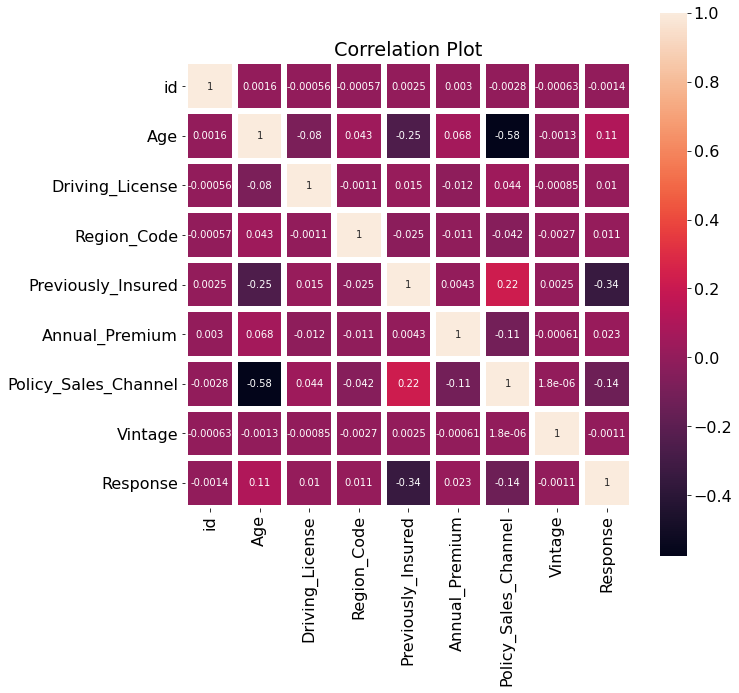

In [17]:
plt.figure(figsize = (10,10))
plt.title("Correlation Plot")
sns.heatmap(df.corr(), linewidth = 5, annot = True, square = True, annot_kws={'size': 10})

## Analisi delle variabili categoriche
Passiamo alle variabili categoriche.

In [29]:
categorical_columns = ["Gender","Driving_License", 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']

Creiamo un grafico a torta per mostrare la distruzione delle categorie dentro ogni variabile.

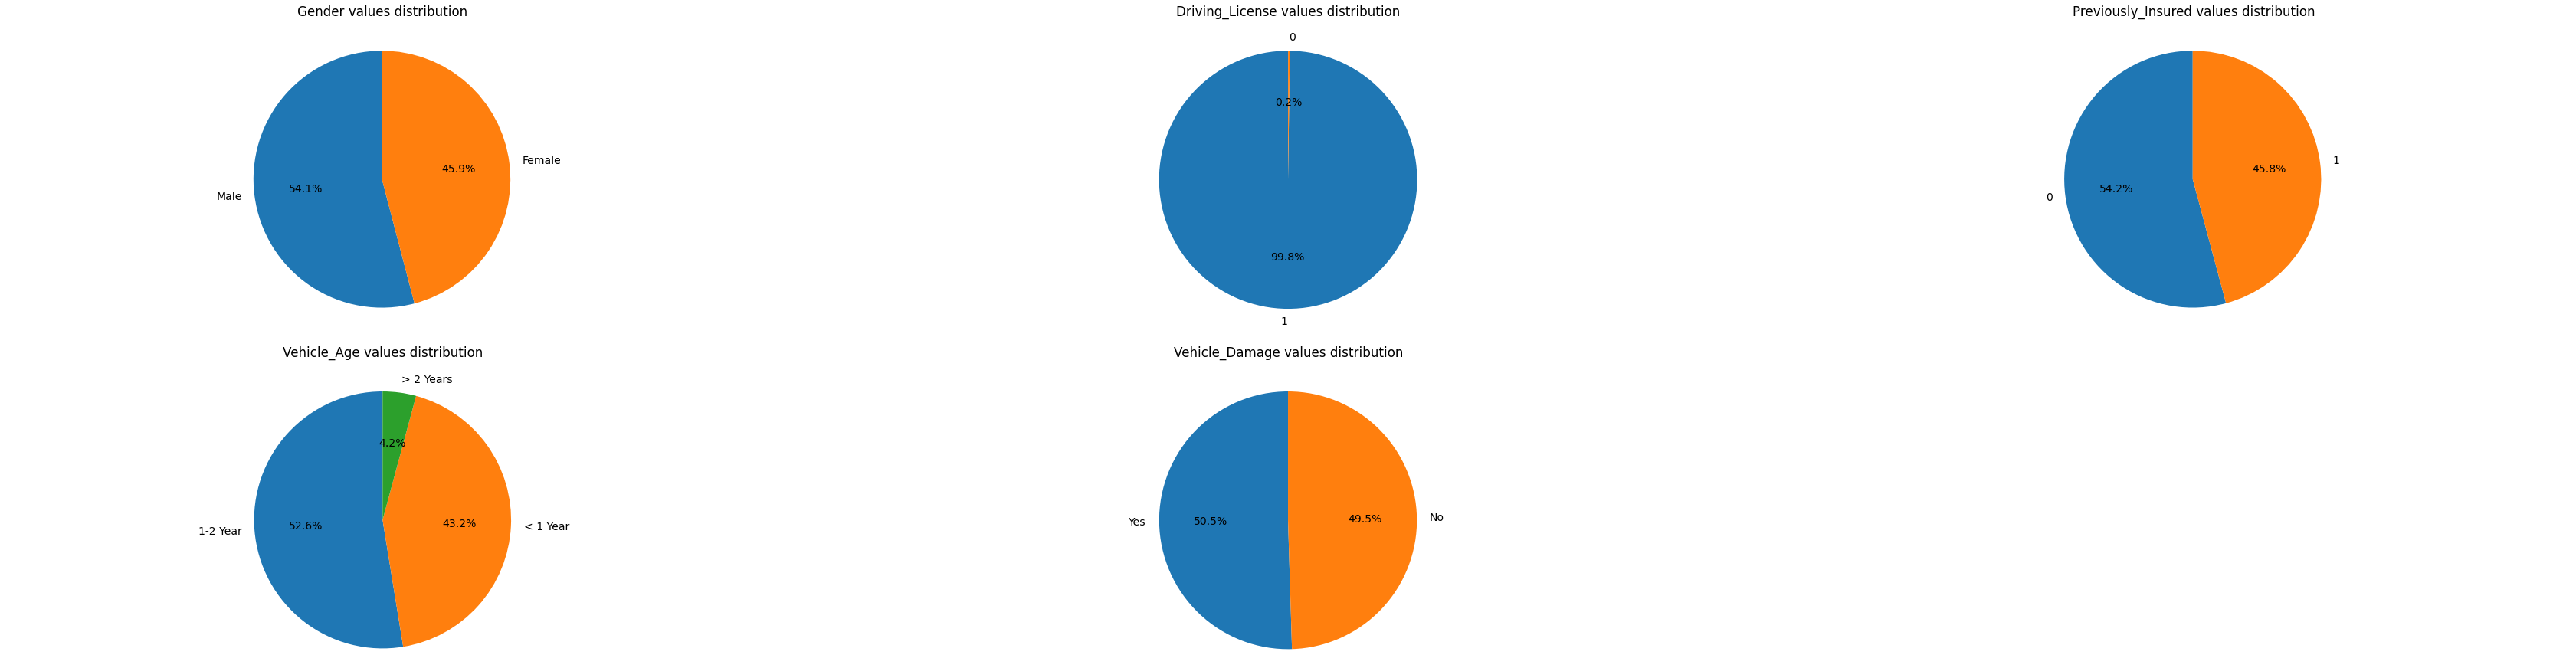

In [35]:
fig = plt.figure()

ncols = 3
nrows = round(len(categorical_columns)/ncols)

for i, column in enumerate(categorical_columns):

  plot = fig.add_subplot(nrows, ncols, i+1)

  df_uniqdist = df[column].value_counts()

  plot.pie(df_uniqdist.values, 
          labels=df_uniqdist.index.values, 
          autopct='%1.1f%%',
          startangle=90)
  
  plot.title.set_text(column+" values distribution")
  plot.axis('equal')

  ttl = plot.title
  ttl.set_position([.5, 1.06])

plt.show()

Vediamo anche, per ogni variabile, quale categoria ha convertito in più vendite.

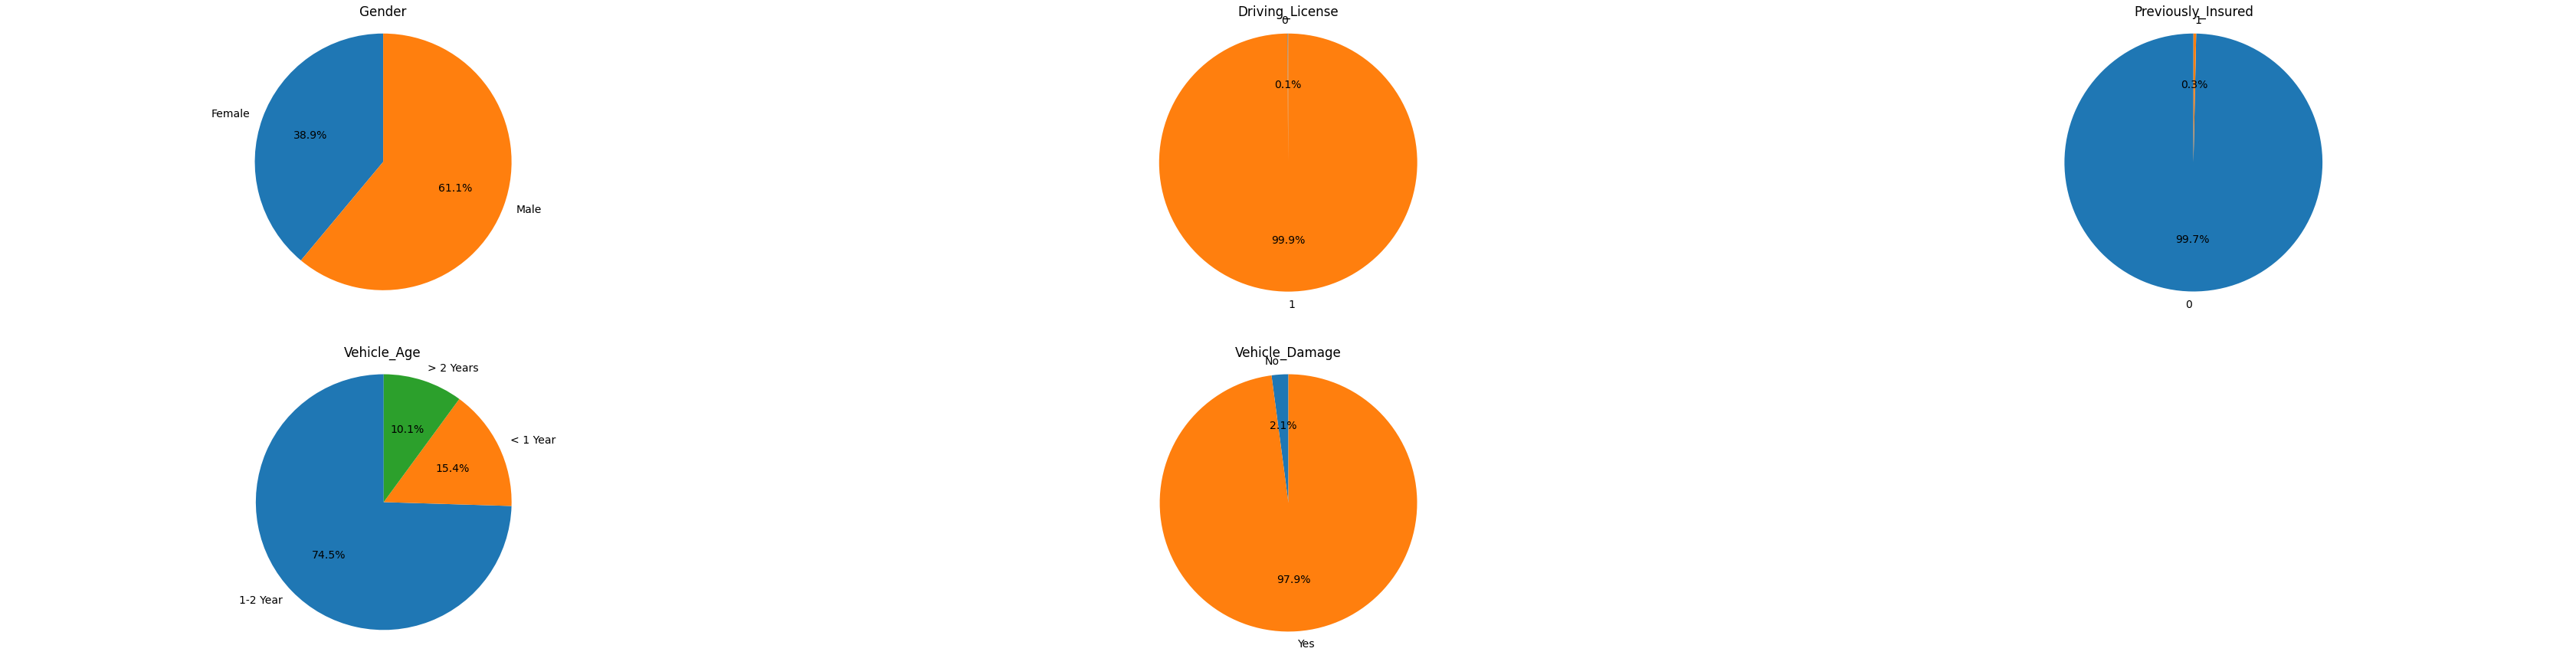

In [39]:
fig = plt.figure()
#fig.set_size_inches(30, 10)

df_count = df.copy()
df_count["count"] = 1

for i, column in enumerate(categorical_columns):

  plot = fig.add_subplot(nrows, ncols, i+1)
  df_tmp = df_count.groupby([column,"Response"]).count()["count"].to_frame().reset_index()
  
  plot.pie(df_tmp[df_tmp["Response"]==1]["count"].values, 
        labels=df_tmp[column].unique(), 
        autopct='%1.1f%%',
        startangle=90)
  
  plot.title.set_text(column)
  plot.axis('equal')

plt.show()

## Approfondiamo Region Code e Policy Sales Channel
Sopra abbiamo trattato Region Code e Policy Sales Channel come variabili continue, è corretto ? No, entrambe hanno un numero di valori unici molto grande, ma rimangono sempre categorie, i valori al loro interno non rappresentano una grandezza.

In [16]:
print("Region codes unici: %d" % df["Region_Code"].unique().shape[0])
print("Policy Sales Channels unici: %d" % df["Policy_Sales_Channel"].unique().shape[0])

Region codes unici: 53
Policy Sales Channels unici: 155


Quindi andiamo ad analizzarle come le variabili categoriche che sono, realizzando dei grafici ad-hoc per ospitare un numero grande di valori. 
Nel primo grafico mostriamo la distribuzione delle categorie dentro le due variabili.

In [18]:
type(df["Region_Code"].value_counts(sort=False))

pandas.core.series.Series

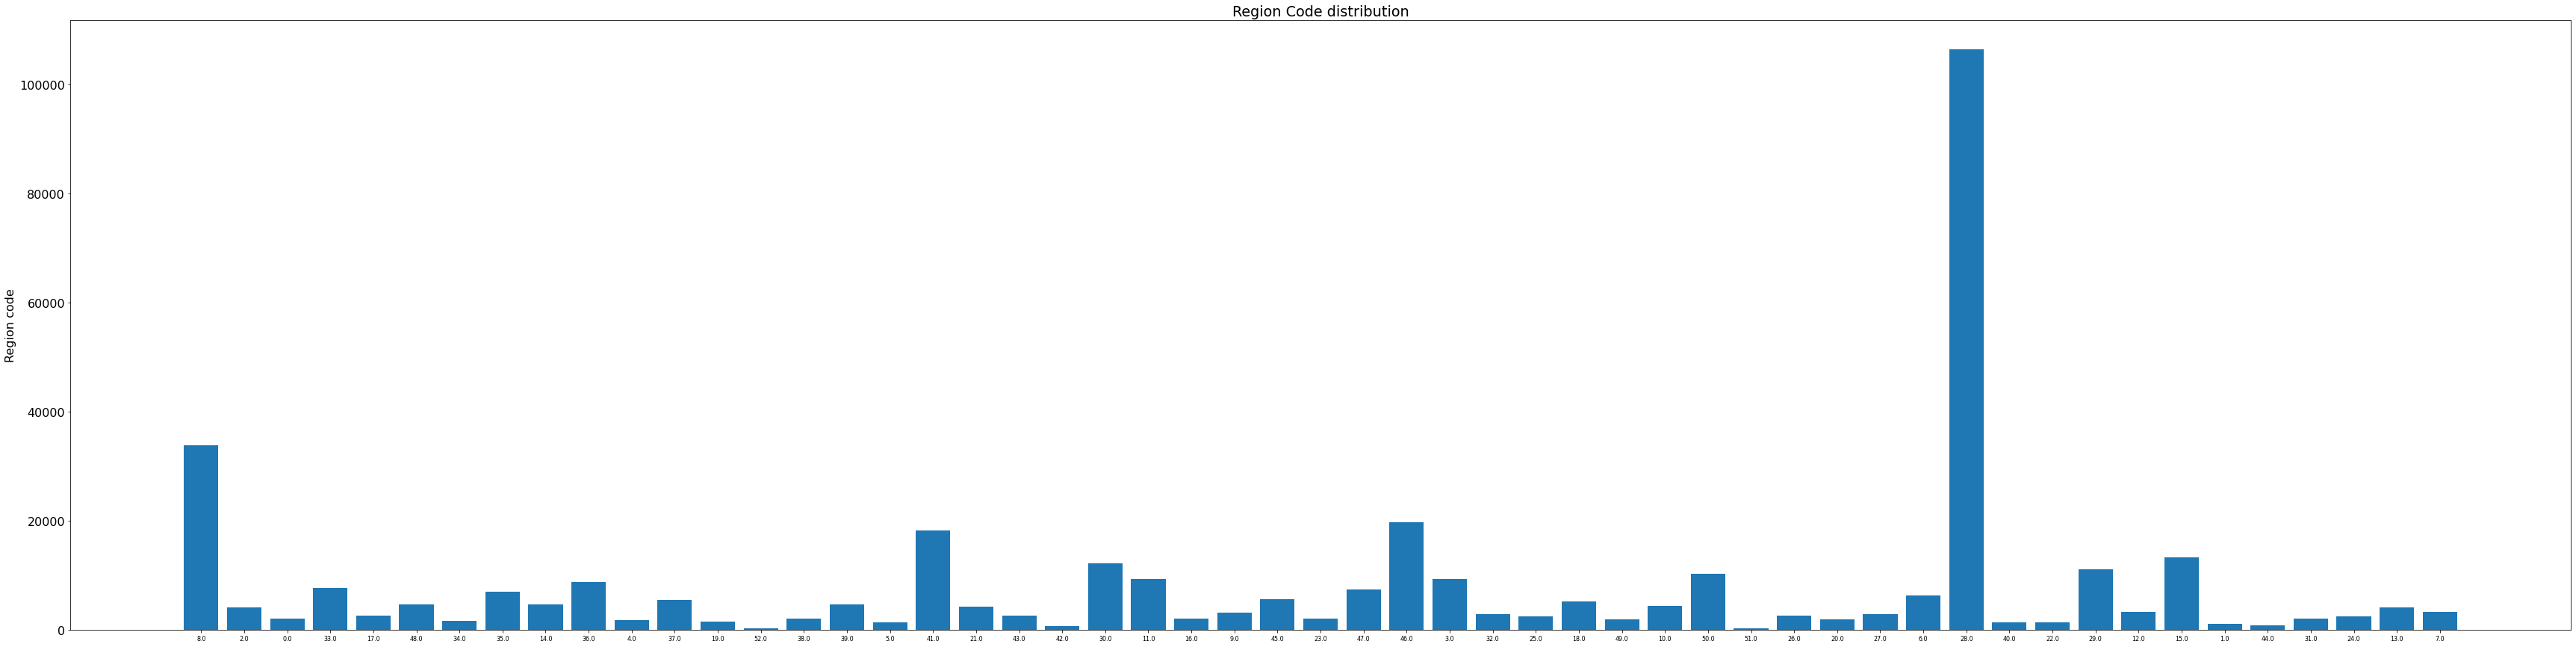

      Region_Code  Region_Code
28.0       106415     0.279225
8.0         33877     0.088891
46.0        19749     0.051820
41.0        18263     0.047921
15.0        13308     0.034919


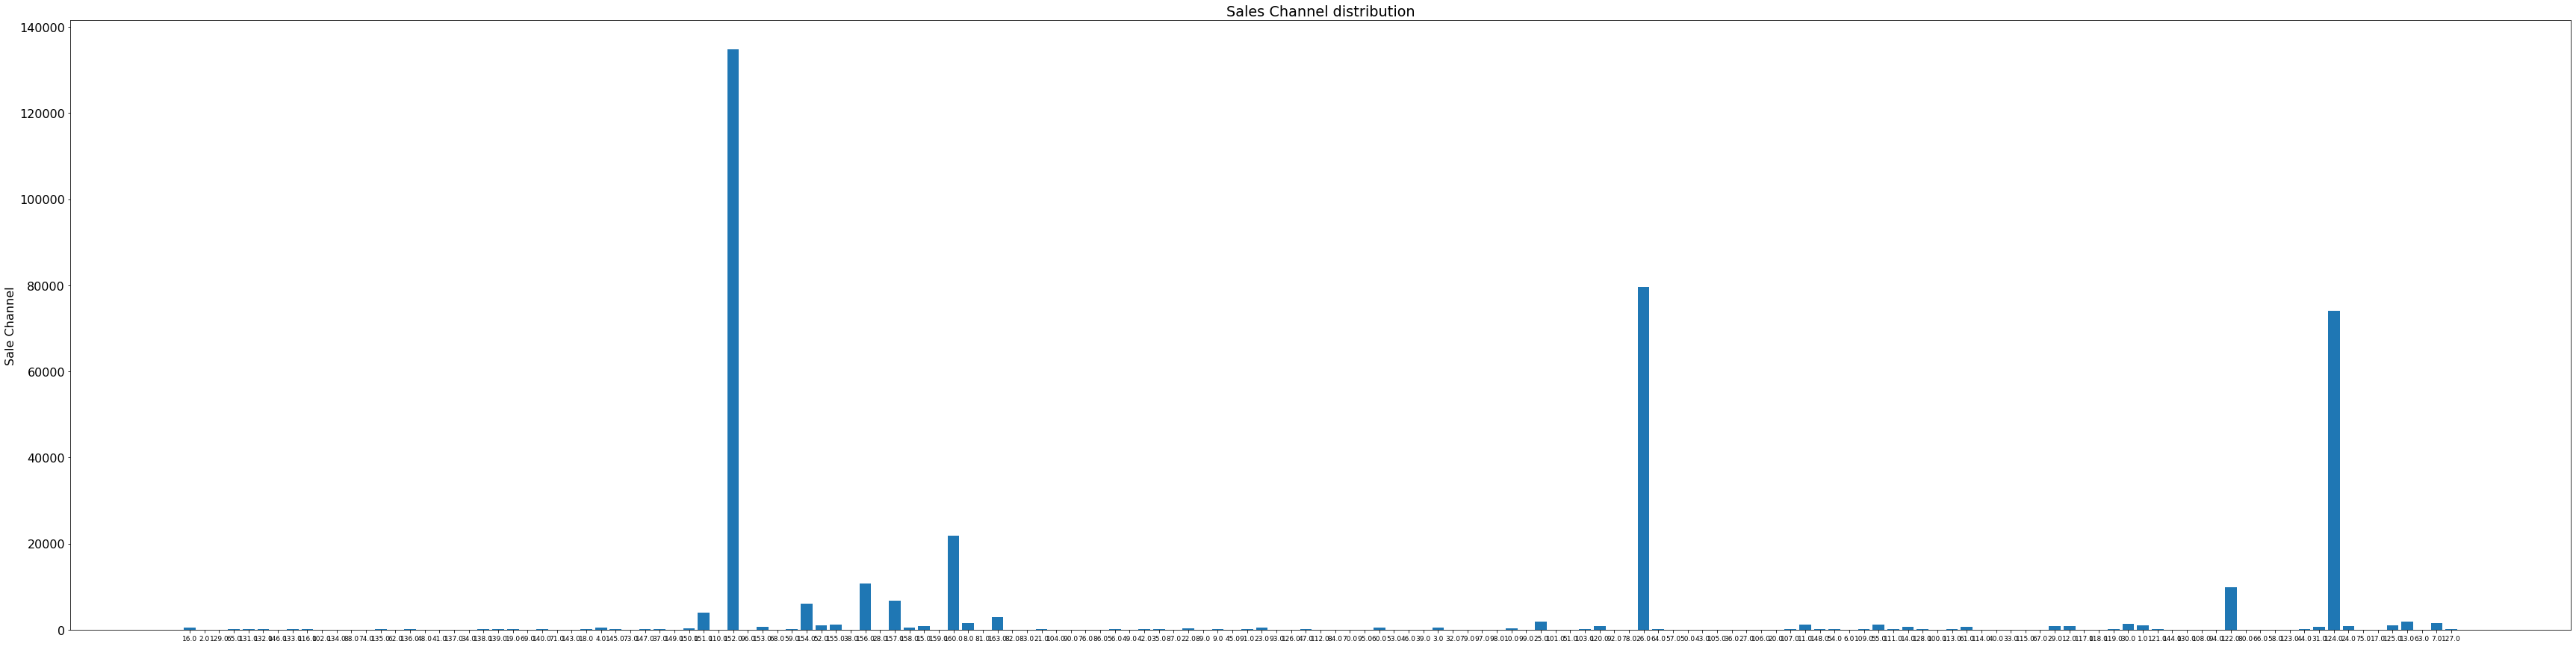

       Policy_Sales_Channel  Policy_Sales_Channel
152.0                134784              0.353663
26.0                  79700              0.209127
124.0                 73995              0.194157
160.0                 21779              0.057146
156.0                 10661              0.027974


In [27]:
def plot_categorical_distribution(df, column, title=None, label=None, ticksize=12, print_first=None):

  serie_uniqdist = df[column].value_counts(sort=False) # otteniamo una series con id=categoia valore=conteggio
  labels = serie_uniqdist.index.values # otteniamo i nomi delle categorie
  y_pos = np.arange(len(labels)) # creiamo un'array di valori equidistanti all'interno dell'intervallo 0,n dove n è il numero di categorie (necessario per il grafico)

  plt.bar(y_pos, serie_uniqdist.values) # creiamo il grafico
  plt.xticks(y_pos, labels, fontsize=ticksize) # mettiamo i nomi delle corrispondenti categorie sull'asse delle x
  plt.ylabel(label) 
  plt.title(title)
  plt.show()

  if print_first:
    total = serie_uniqdist.sum()
    serie_uniqdist = serie_uniqdist.sort_values(ascending=False)
    serie_percentage = serie_uniqdist/total # per calcolare la percentuale di presenza dividiamo per il numero totale
    print(pd.concat([serie_uniqdist, serie_percentage], axis=1).head(print_first)) # con concat uniamo le due serie come colonne di un dataframe


plot_categorical_distribution(df, "Region_Code", title="Region Code distribution", label="Region code", ticksize=8, print_first=300)
plot_categorical_distribution(df, "Policy_Sales_Channel", title="Sales Channel distribution", label="Sale Channel", ticksize=9, print_first=300)

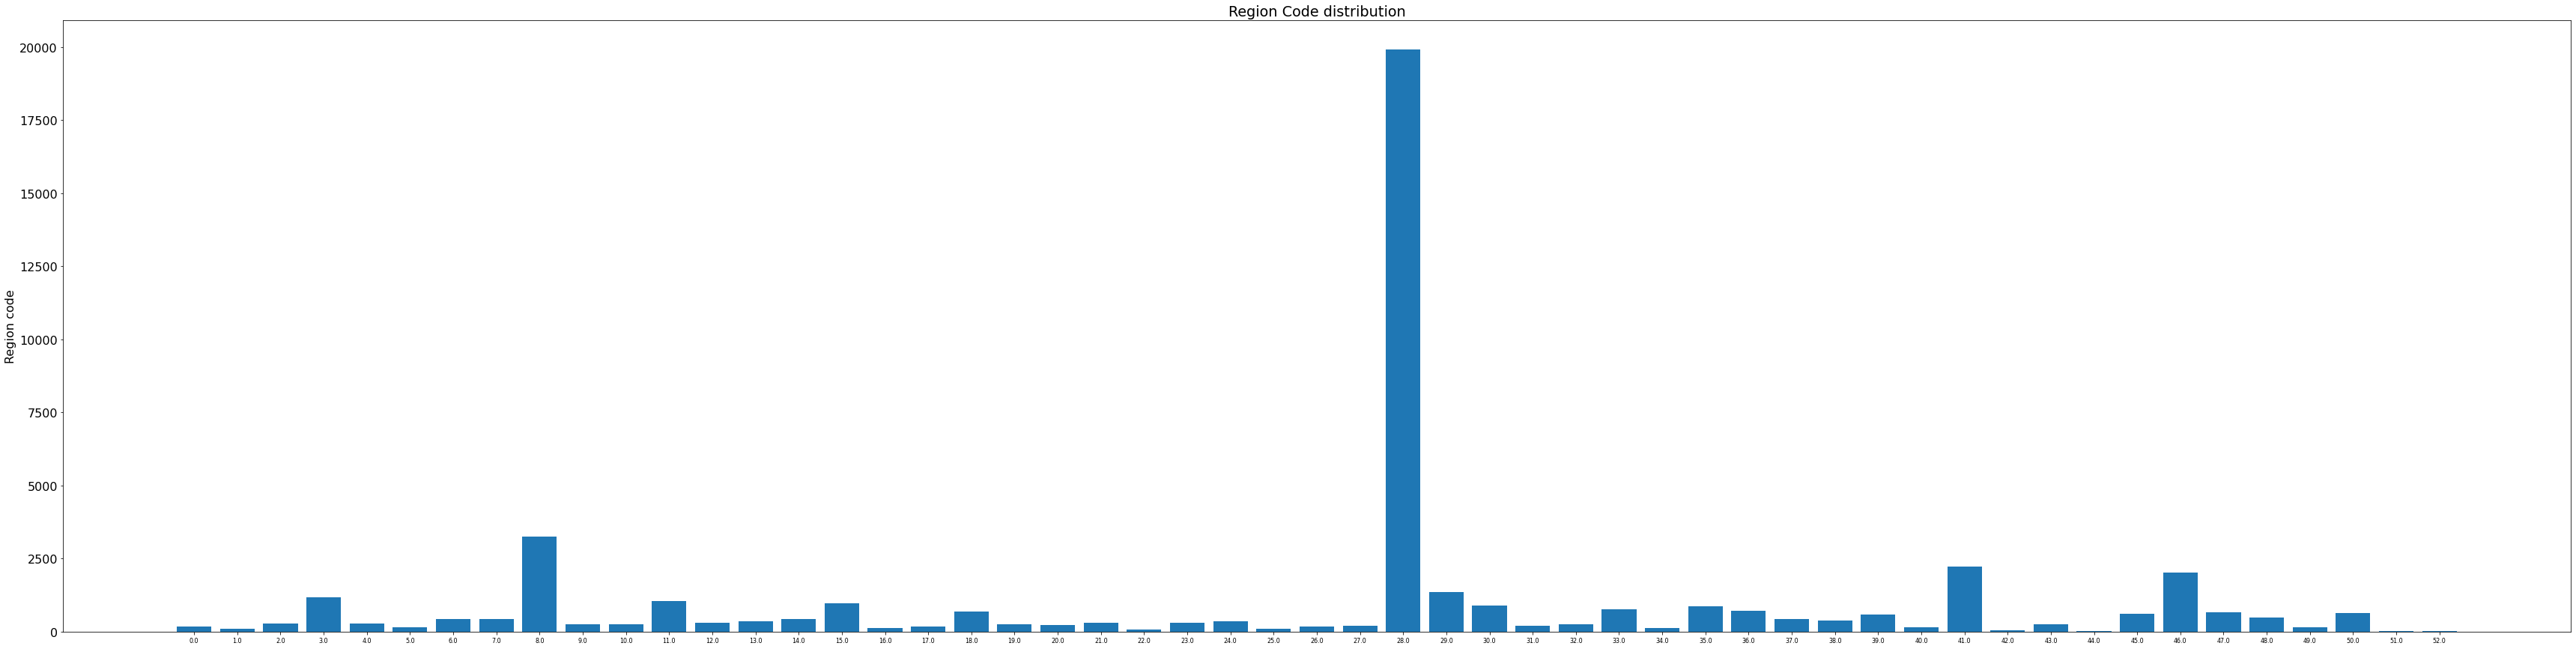

             Response  Percentage
Region_Code                      
28.0            19917    0.187163
8.0              3257    0.096142
41.0             2224    0.121776
46.0             2032    0.102891
29.0             1365    0.123362
3.0              1181    0.127662
11.0             1041    0.112760
15.0              958    0.071987
30.0              900    0.073825
35.0              865    0.124604
33.0              760    0.099294
36.0              703    0.079914
18.0              678    0.131574
47.0              652    0.087682
50.0              642    0.062677
45.0              615    0.109723
39.0              574    0.123600
48.0              477    0.101901
6.0               439    0.069904
37.0              436    0.079258
7.0               432    0.131747
14.0              422    0.090209
38.0              389    0.192004
13.0              364    0.090188
24.0              342    0.141615
12.0              312    0.097561
21.0              303    0.071027
23.0          

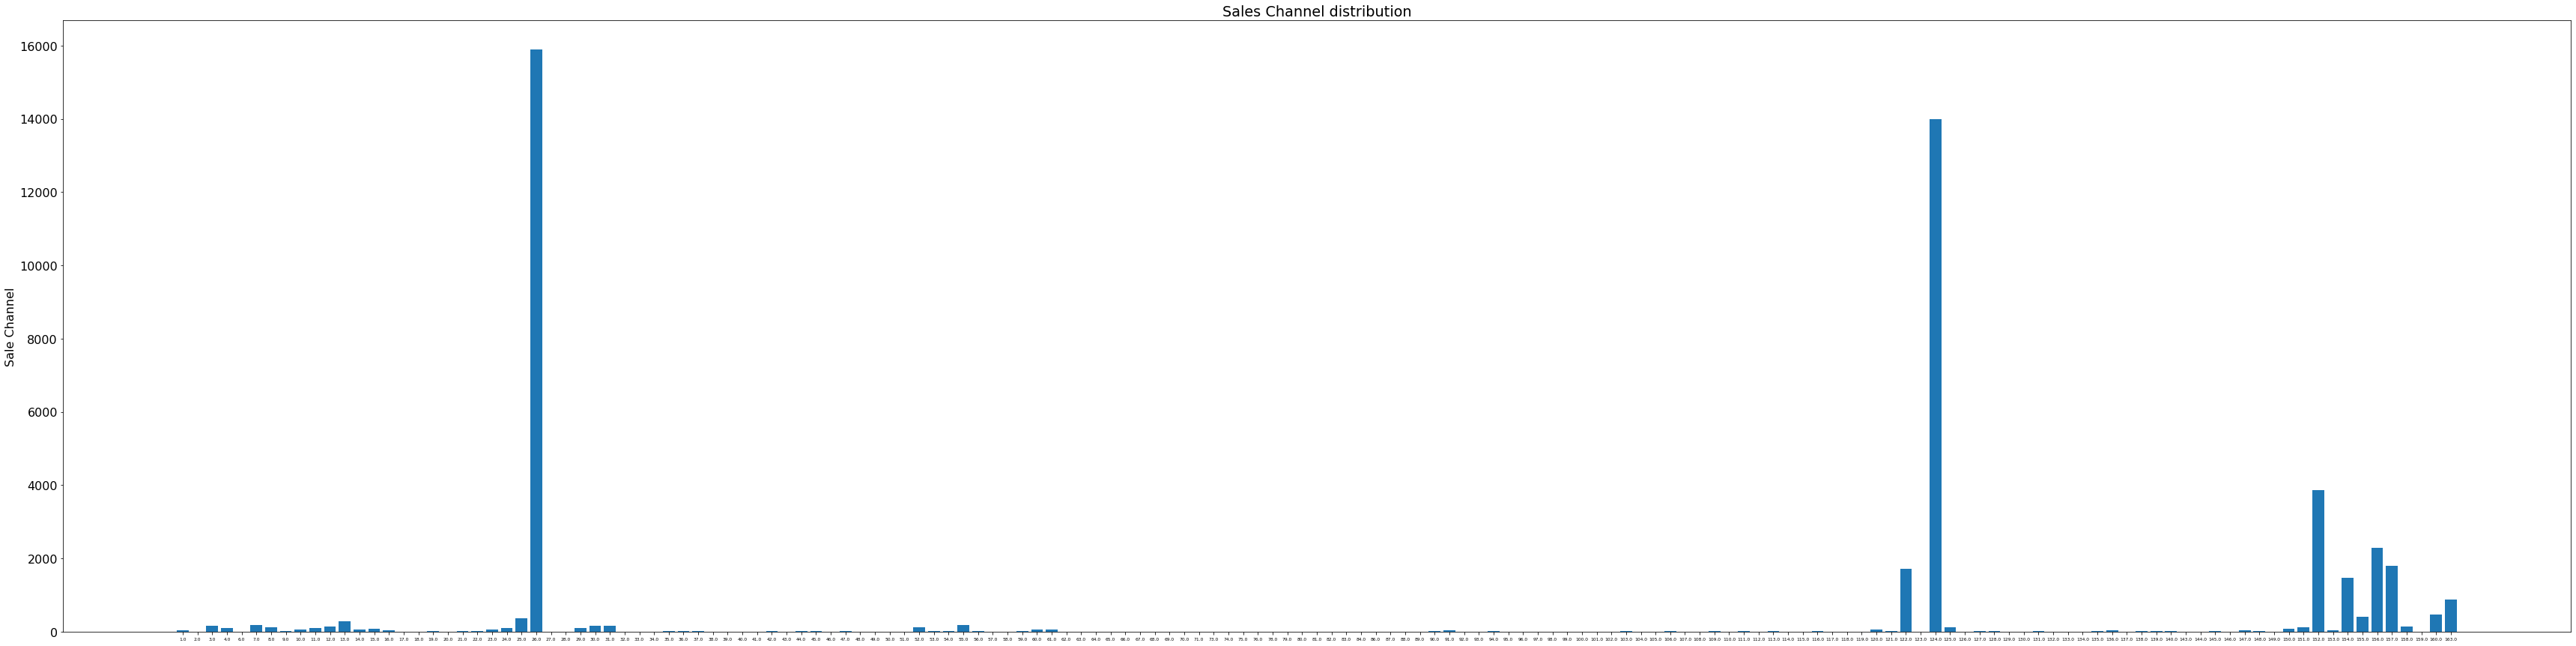

                      Response  Percentage
Policy_Sales_Channel                      
26.0                     15891    0.199385
124.0                    13996    0.189148
152.0                     3858    0.028624
156.0                     2297    0.215458
157.0                     1794    0.268402
122.0                     1720    0.173212
154.0                     1474    0.245954
163.0                      880    0.304183
160.0                      475    0.021810
155.0                      395    0.320097
25.0                       369    0.199675
13.0                       275    0.147453
55.0                       189    0.149525
7.0                        182    0.113892
31.0                       160    0.253566
3.0                        159    0.304015
30.0                       156    0.110638
158.0                      135    0.274390
12.0                       132    0.168582
125.0                      127    0.123782
8.0                        125    0.082508
151.0      

In [22]:
def plot_categorical_correlation(df, column, target, title=None, label=None, ticksize=12, print_first=None):

  df_tmp = df[[column, target]].copy()
  df_tmp = df_tmp.groupby([column]) # raggruppiamo in base alla categoria
  df_sum = df_tmp.sum()
  df_count = df_tmp.count()

  df_sum["Percentage"] = df_sum["Response"]/df_count["Response"] # calcoliamo la percentaule di risposte positive e negative

  values = df_sum["Response"].values
  labels = df_sum.index.values
  y_pos = np.arange(len(labels))

  plt.bar(y_pos, values)
  plt.xticks(y_pos, labels, fontsize=ticksize)
  plt.ylabel(label)
  plt.title(title)
  plt.show()

  if print_first:
    print(df_sum.sort_values("Response", ascending=False).head(print_first))

  
plot_categorical_correlation(df, "Region_Code", "Response", title="Region Code distribution", label="Region code", ticksize=8, print_first=200)
plot_categorical_correlation(df, "Policy_Sales_Channel", "Response", title="Sales Channel distribution", label="Sale Channel", ticksize=6, print_first=200)

## Analisi del target
E il target ? Sappiamo che i possibili valori sono 0 e 1, ma quanti 0 e quanti 1 ? Diamo uno sguardo alla distribuzione.

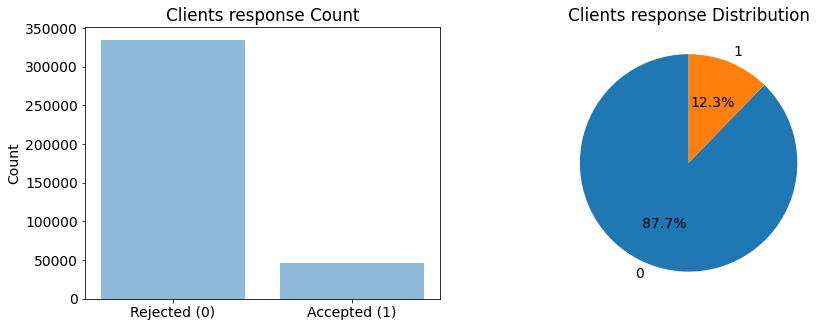

In [52]:
fig, axis = plt.subplots(1, 2, figsize = (14, 5))

df_uniqdist = df["Response"].value_counts()
y_pos = np.arange(len(df_uniqdist.index.values))

axis[0].bar(y_pos, df_uniqdist.values, align='center', alpha=0.5)
axis[0].set_xticks(y_pos)
axis[0].set_xticklabels(("Rejected (0)","Accepted (1)"))
axis[0].set_ylabel('Count')
axis[0].set_title('Clients response Count')

axis[1].pie(df_uniqdist.values, 
          labels=df_uniqdist.index.values, 
          autopct='%1.1f%%',
          startangle=90)

axis[1].set_title('Clients response Distribution')

plt.show()

## Feature Engineering
Tutto bello, passiamo a processare le features, iniziamo droppando l'id che non serve mai a nulla.

In [ ]:
df = df.drop(["id"], axis=1)

Codifichiamo le variabili categoriche da stringhe a numeri.

In [25]:
df["Gender"] = df["Gender"].map({'Male':1, 'Female':0})
df["Vehicle_Damage"] = df["Vehicle_Damage"].map({'Yes':1, 'No':0})
df["Vehicle_Age"] = df["Vehicle_Age"].map({'> 2 Years':2, '1-2 Year':1.5, '< 1 Year':1 })
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2.0,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1.5,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2.0,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,1.0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,1.0,0,27496.0,152.0,39,0


Ora che abbiamo tutto codificato in numeri, possiamo calcolare la mutua dipendenza tramite informazione mutua<sup>[2](#references)</sup> tra features e target.

In [29]:
df_features = df.drop("Response", axis=1)
mic = mutual_info_classif(df_features, df["Response"])
df_mic = pd.DataFrame({'column':df_features.columns, 'correlation':mic})
df_mic = df_mic.sort_values(by=['correlation'], ascending=False)
df_mic.head(100)

,column,correlation
4,Previously_Insured,0.099363
6,Vehicle_Damage,0.094797
2,Driving_License,0.073689
8,Policy_Sales_Channel,0.059142
5,Vehicle_Age,0.056648
1,Age,0.031261
0,Gender,0.022123
3,Region_Code,0.015167
7,Annual_Premium,0.004066
9,Vintage,0.000513


Il blocco di codice qua sotto ci permette di raggruppare i Policy_Sales_Channel meno presenti in un unico gruppo, questo per ridurre il numero di features che otterremo con il one-hot-encoding. Dato che abbiamo un pozzo di dati, possiamo pure usare una colonna per ogni categoria senza preoccuparci.

In [ ]:
"""
def group_channels(channel):
  positive_channels = [38., 124., 152., 156., 157., 122.]
  return channel if channel in positive_channels else 0

df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].apply(group_channels)
df.head()
"""

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,0.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,0.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,0.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Nel caso seguente raggrupperemo l'eta in fasce di età, trasformando la variabile continua Age in una variabile categorica quantitativa. Come sopra, avendo tanti dati, non ci concludiamo nulla a farlo.

In [ ]:
"""
def group_age(age):
  if age<=30:
    return "20-30"
  if age<=40:
    return "30-40"
  if age<=50:
    return "40-50"
  if age<=60:
    return "50-60"
  return "60+"

df["Age"] = df["Age"].apply(group_age)
df.head()
"""

Eseguiamo il one-hot-econding delle variabili categoriche qualitative non binarie.

In [59]:
df = pd.get_dummies(df, columns=["Policy_Sales_Channel", "Region_Code"])
df.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Policy_Sales_Channel_1.0,Policy_Sales_Channel_2.0,Policy_Sales_Channel_3.0,Policy_Sales_Channel_4.0,Policy_Sales_Channel_6.0,Policy_Sales_Channel_7.0,Policy_Sales_Channel_8.0,Policy_Sales_Channel_9.0,Policy_Sales_Channel_10.0,Policy_Sales_Channel_11.0,Policy_Sales_Channel_12.0,Policy_Sales_Channel_13.0,Policy_Sales_Channel_14.0,Policy_Sales_Channel_15.0,Policy_Sales_Channel_16.0,Policy_Sales_Channel_17.0,Policy_Sales_Channel_18.0,Policy_Sales_Channel_19.0,Policy_Sales_Channel_20.0,Policy_Sales_Channel_21.0,Policy_Sales_Channel_22.0,Policy_Sales_Channel_23.0,Policy_Sales_Channel_24.0,Policy_Sales_Channel_25.0,Policy_Sales_Channel_26.0,Policy_Sales_Channel_27.0,Policy_Sales_Channel_28.0,Policy_Sales_Channel_29.0,Policy_Sales_Channel_30.0,Policy_Sales_Channel_31.0,Policy_Sales_Channel_32.0,...,Region_Code_13.0,Region_Code_14.0,Region_Code_15.0,Region_Code_16.0,Region_Code_17.0,Region_Code_18.0,Region_Code_19.0,Region_Code_20.0,Region_Code_21.0,Region_Code_22.0,Region_Code_23.0,Region_Code_24.0,Region_Code_25.0,Region_Code_26.0,Region_Code_27.0,Region_Code_28.0,Region_Code_29.0,Region_Code_30.0,Region_Code_31.0,Region_Code_32.0,Region_Code_33.0,Region_Code_34.0,Region_Code_35.0,Region_Code_36.0,Region_Code_37.0,Region_Code_38.0,Region_Code_39.0,Region_Code_40.0,Region_Code_41.0,Region_Code_42.0,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
0,1,44,1,0,2.0,1,40454.0,217,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,76,1,0,1.5,0,33536.0,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,47,1,0,2.0,1,38294.0,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,21,1,1,1.0,0,28619.0,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,29,1,1,1.0,0,27496.0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Creiamo gli array per addestramento e test.

In [60]:
X = df.drop(["Response"], axis=1).values
y = df[["Response"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Applichiamo la standardizzazione per portare i dati su una scala comune.


In [33]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Neural Network
Dato che dovremo definire l'architettura della rete neurale più volte, definiamo una funzione per farlo.

In [48]:
def build_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

Configuriamo il modello e avviamo l'addestramento, 5 epoche basteranno.

In [49]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.1)

Epoch 1/5
1072/1072 [==============================] - 7s 4ms/step - loss: 0.2991 - accuracy: 0.8768 - val_loss: 0.2703 - val_accuracy: 0.8784
Epoch 2/5
1072/1072 [==============================] - 4s 3ms/step - loss: 0.2688 - accuracy: 0.8773 - val_loss: 0.2705 - val_accuracy: 0.8784
Epoch 3/5
1072/1072 [==============================] - 4s 3ms/step - loss: 0.2669 - accuracy: 0.8775 - val_loss: 0.2679 - val_accuracy: 0.8784
Epoch 4/5
1072/1072 [==============================] - 4s 3ms/step - loss: 0.2661 - accuracy: 0.8774 - val_loss: 0.2685 - val_accuracy: 0.8784
Epoch 5/5
1072/1072 [==============================] - 4s 3ms/step - loss: 0.2665 - accuracy: 0.8765 - val_loss: 0.2673 - val_accuracy: 0.8784


In [50]:
model.evaluate(X_test, y_test)

2382/2382 [==============================] - 4s 2ms/step - loss: 0.2684 - accuracy: 0.8765


[0.268436461687088, 0.8765186071395874]

Il risultato è buono su train, validation e test. Troppo buono, essendo il dataset sbilanciato verso la classe negativa, è molto probabile che il modello non stia facendo altro che predire sempre la classe negativa. Verifichiamolo stampando una matrice di confusione e calcolando presion e recall<sup>[3](#references)</sup>

Precision: 0.77
Recall: 0.95


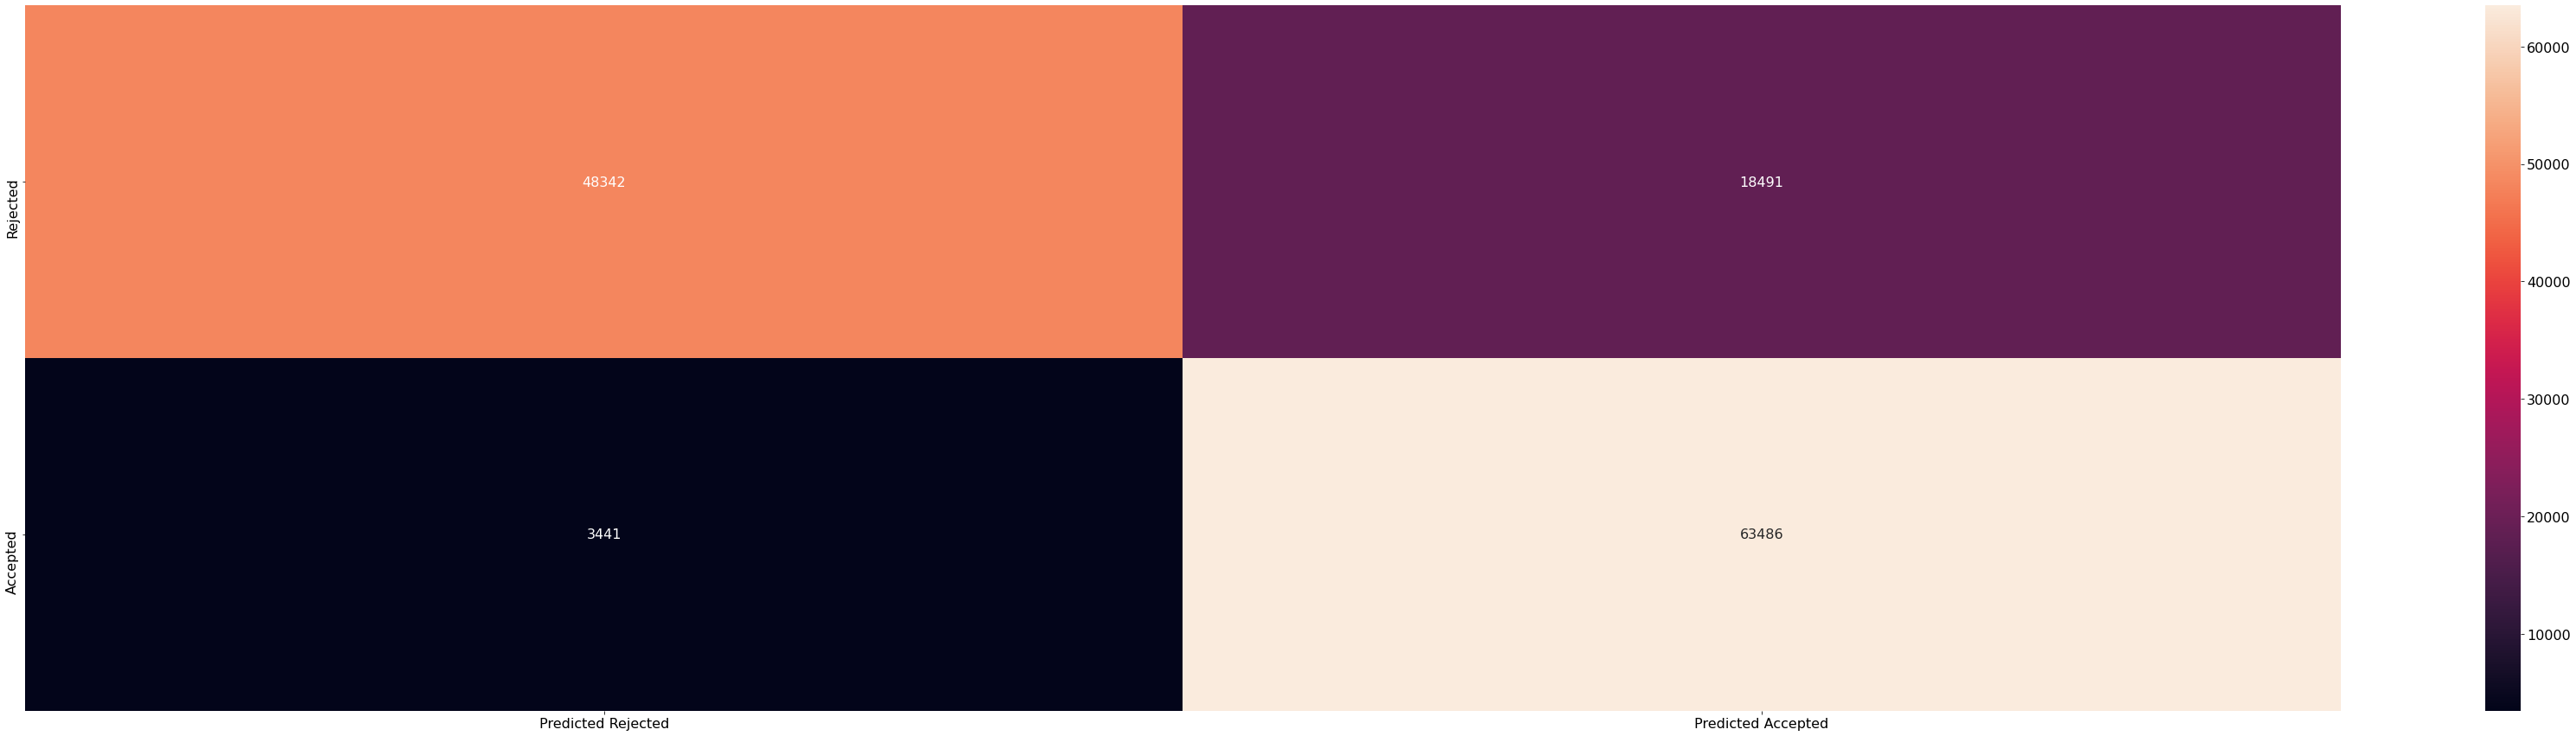

In [67]:
def plot_confusion_matrix(model, labels=["Negative", "Positive"], threeshold=0.5, show_precision=True, show_recall=True):

  y_proba = model.predict(X_test)
  y_pred = np.where(y_proba>threeshold,1,0)
  cm = confusion_matrix(y_test, y_pred) # tn, fp, fn, tp 

  df_cm = pd.DataFrame(cm, index = labels,
                    columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt='g')

  if show_precision:
    # Quale percentuale di classificazione positive erano effettivamente positive ?
    print("Precision: %.2f" % (cm[1][1]/(cm[1][1]+cm[0][1])))
  if show_recall:
    # Quale percentuale di osservazioni positive sono state classificate come positive ?
    print("Recall: %.2f" % (cm[1][1]/(cm[1][1]+cm[1][0])))

plot_confusion_matrix(model, ["Rejected", "Accepted"])

Proprio così ! Vediamo alcune tecniche per poter lavorare su un dataset fortemente sbilanciato

## Tecnica 1: Class Weighting
La prima tecnica consiste nel applicare un peso positivo a classe più debole, ed eventualmente un peso positivo alla classe più forte. Nel nostro caso ho verificato che applicare anche un peso negativo va a penalizzare eccessivamente la classe negativa.

In [34]:
total = y.shape[0]
pos = y[y==1].shape[0]
pos_weight = (1 / pos)*(total)/2.0

# Non applichiamo un peso negativo
# perchè penalizza troppo la classe negativa
# neg = y[y==0].shape[0]
# neg_weight = (1 / neg)*(total)/2.0

class_weight = {0: 1, 1: pos_weight}

Per applicare i pesi posiamo usare il parametro *class_weight* del metodo *fit*.

In [56]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, class_weight=class_weight, batch_size=128, validation_split=0.1)

Epoch 1/10
2144/2144 [==============================] - 8s 3ms/step - loss: 0.6281 - accuracy: 0.7472 - val_loss: 0.3781 - val_accuracy: 0.7395
Epoch 2/10
2144/2144 [==============================] - 7s 3ms/step - loss: 0.5818 - accuracy: 0.7522 - val_loss: 0.3912 - val_accuracy: 0.7343
Epoch 3/10
2144/2144 [==============================] - 7s 3ms/step - loss: 0.5805 - accuracy: 0.7522 - val_loss: 0.3811 - val_accuracy: 0.7453
Epoch 4/10
2144/2144 [==============================] - 7s 3ms/step - loss: 0.5784 - accuracy: 0.7538 - val_loss: 0.3700 - val_accuracy: 0.7517
Epoch 5/10
2144/2144 [==============================] - 7s 3ms/step - loss: 0.5716 - accuracy: 0.7557 - val_loss: 0.3540 - val_accuracy: 0.7532
Epoch 6/10
2144/2144 [==============================] - 7s 3ms/step - loss: 0.5728 - accuracy: 0.7574 - val_loss: 0.3628 - val_accuracy: 0.7569
Epoch 7/10
2144/2144 [==============================] - 7s 3ms/step - loss: 0.5677 - accuracy: 0.7631 - val_loss: 0.3586 - val_accuracy:

In [57]:
model.evaluate(X_test, y_test)

2382/2382 [==============================] - 4s 2ms/step - loss: 0.3623 - accuracy: 0.7636


[0.36227166652679443, 0.7635853290557861]

Precision: 0.32
Recall: 0.80


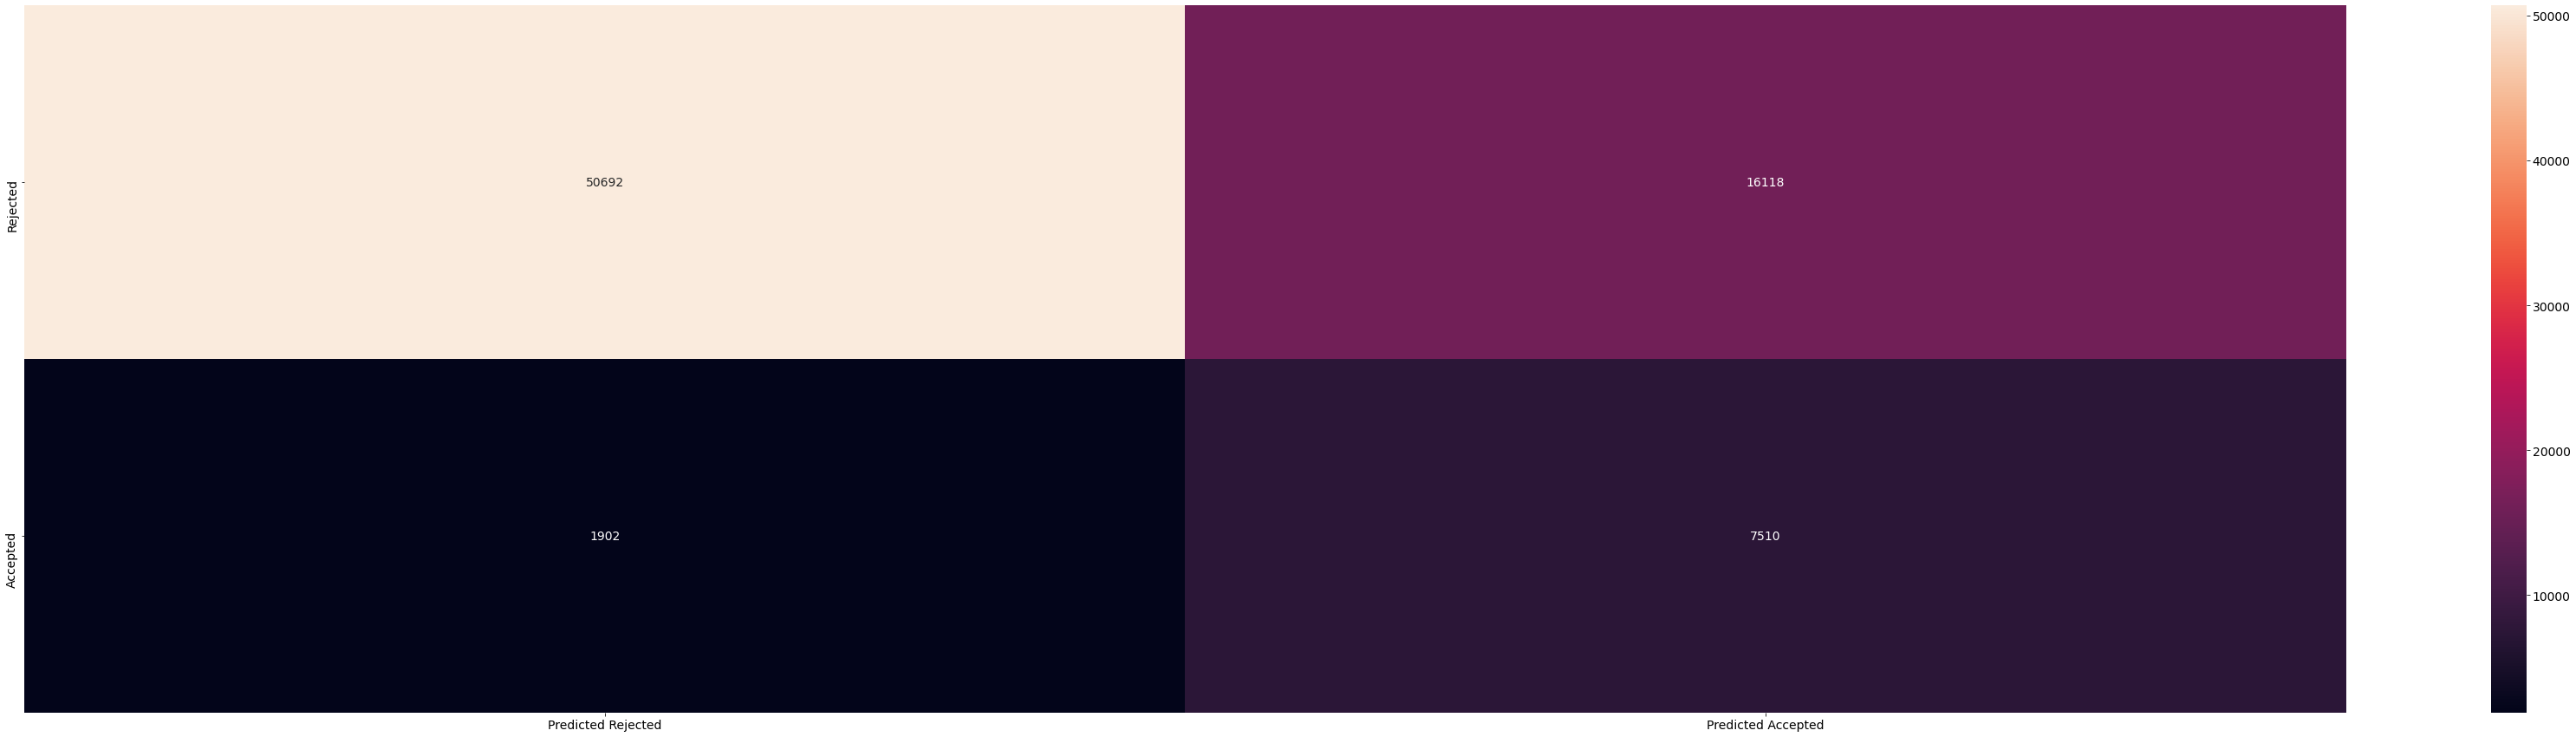

In [58]:
plot_confusion_matrix(model, ["Rejected", "Accepted"])

Decisamente meglio.

## Tecnica 2: Undersampling
L'undersampling consiste nel rimuovere di proposito esempi appartenenti alla classe più forte, in modo tale da pareggiare il numero con la classe più debole. 

Per farlo iniziamo definendo due funzioni di supporto, la prima ci permette di divedere il dataframe in base al valore di y. 

In [39]:
def split_data_by_label(df, target_column):
  
  y = df[target_column].values
  bool_labels = y!=0 # creiamo una maschera binaria per filtrare le righe in base al valore del target

  X_pos = df[bool_labels]
  X_neg = df[~bool_labels] # la tilde inverte la maschera binaria

  X_pos = X_pos.drop(target_column, axis=1).values
  X_neg = X_neg.drop(target_column, axis=1).values

  y_pos = y[bool_labels]
  y_neg = y[~bool_labels]

  return X_pos, X_neg, y_pos, y_neg

La seconda rimette insieme il dataset e lo shakera un po'

In [40]:
def concatenate(X_pos, X_neg, y_pos, y_neg):
  
  X_concat = np.concatenate([X_neg, X_pos], axis=0)
  y_concat = np.concatenate([y_neg, y_pos], axis=0)

  order = np.arange(len(y_concat))
  np.random.shuffle(order)
  X_concat = X_concat[order]
  y_concat = y_concat[order]

  return X_concat, y_concat

Ora definiamo la funzione che applicherà l'undersampling.

In [43]:
def undersample(df, target_column):
  
  X_pos, X_neg, y_pos, y_neg = split_data_by_label(df, target_column)
  
  ids = np.arange(len(X_neg)) # creiamo un'array di valori equidistanti all'interno dell'intervallo 0,n dove n è il numero di esempi appartenenti alla classe negativa
                              # ids funge da lista di indici di X_neg

  choices = np.random.choice(ids, len(X_pos))  # campioniamo un numero di incidi pari al numero di esempi appartenenti alla classe positiva

  X_neg_res = X_neg[choices] # usiamo gli indici campionati per filtrare
  y_neg_res = y_neg[choices] # usiamo gli stessi indici campionati per filtrare

  res_features, res_labels = concatenate(X_pos, X_neg_res, y_pos, y_neg_res)
  return res_features, res_labels

In [44]:
X_undersampled, y_undersampled = undersample(df, "Response")
print("Number of samples: "+str(X_undersampled.shape))
print("Labels distribution: "+str(np.unique(y_undersampled,return_counts=True)))

Number of samples: (93420, 10)
Labels distribution: (array([0, 1]), array([46710, 46710]))


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2)

In [46]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [49]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=512, validation_split=0.1)

Epoch 1/10
132/132 [==============================] - 2s 8ms/step - loss: 0.4902 - accuracy: 0.7707 - val_loss: 0.4319 - val_accuracy: 0.7923
Epoch 2/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4286 - accuracy: 0.7971 - val_loss: 0.4310 - val_accuracy: 0.7930
Epoch 3/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4283 - accuracy: 0.7931 - val_loss: 0.4371 - val_accuracy: 0.7902
Epoch 4/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4331 - accuracy: 0.7891 - val_loss: 0.4330 - val_accuracy: 0.7902
Epoch 5/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4240 - accuracy: 0.7967 - val_loss: 0.4318 - val_accuracy: 0.7933
Epoch 6/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4262 - accuracy: 0.7950 - val_loss: 0.4311 - val_accuracy: 0.7913
Epoch 7/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4282 - accuracy: 0.7930 - val_loss: 0.4298 - val_accuracy: 0.7914
Epoch 

In [69]:
model.evaluate(X_test, y_test)

584/584 [==============================] - 1s 2ms/step - loss: 0.4286 - accuracy: 0.8007


[0.4285649061203003, 0.8006851077079773]

Precision: 0.75
Recall: 0.92


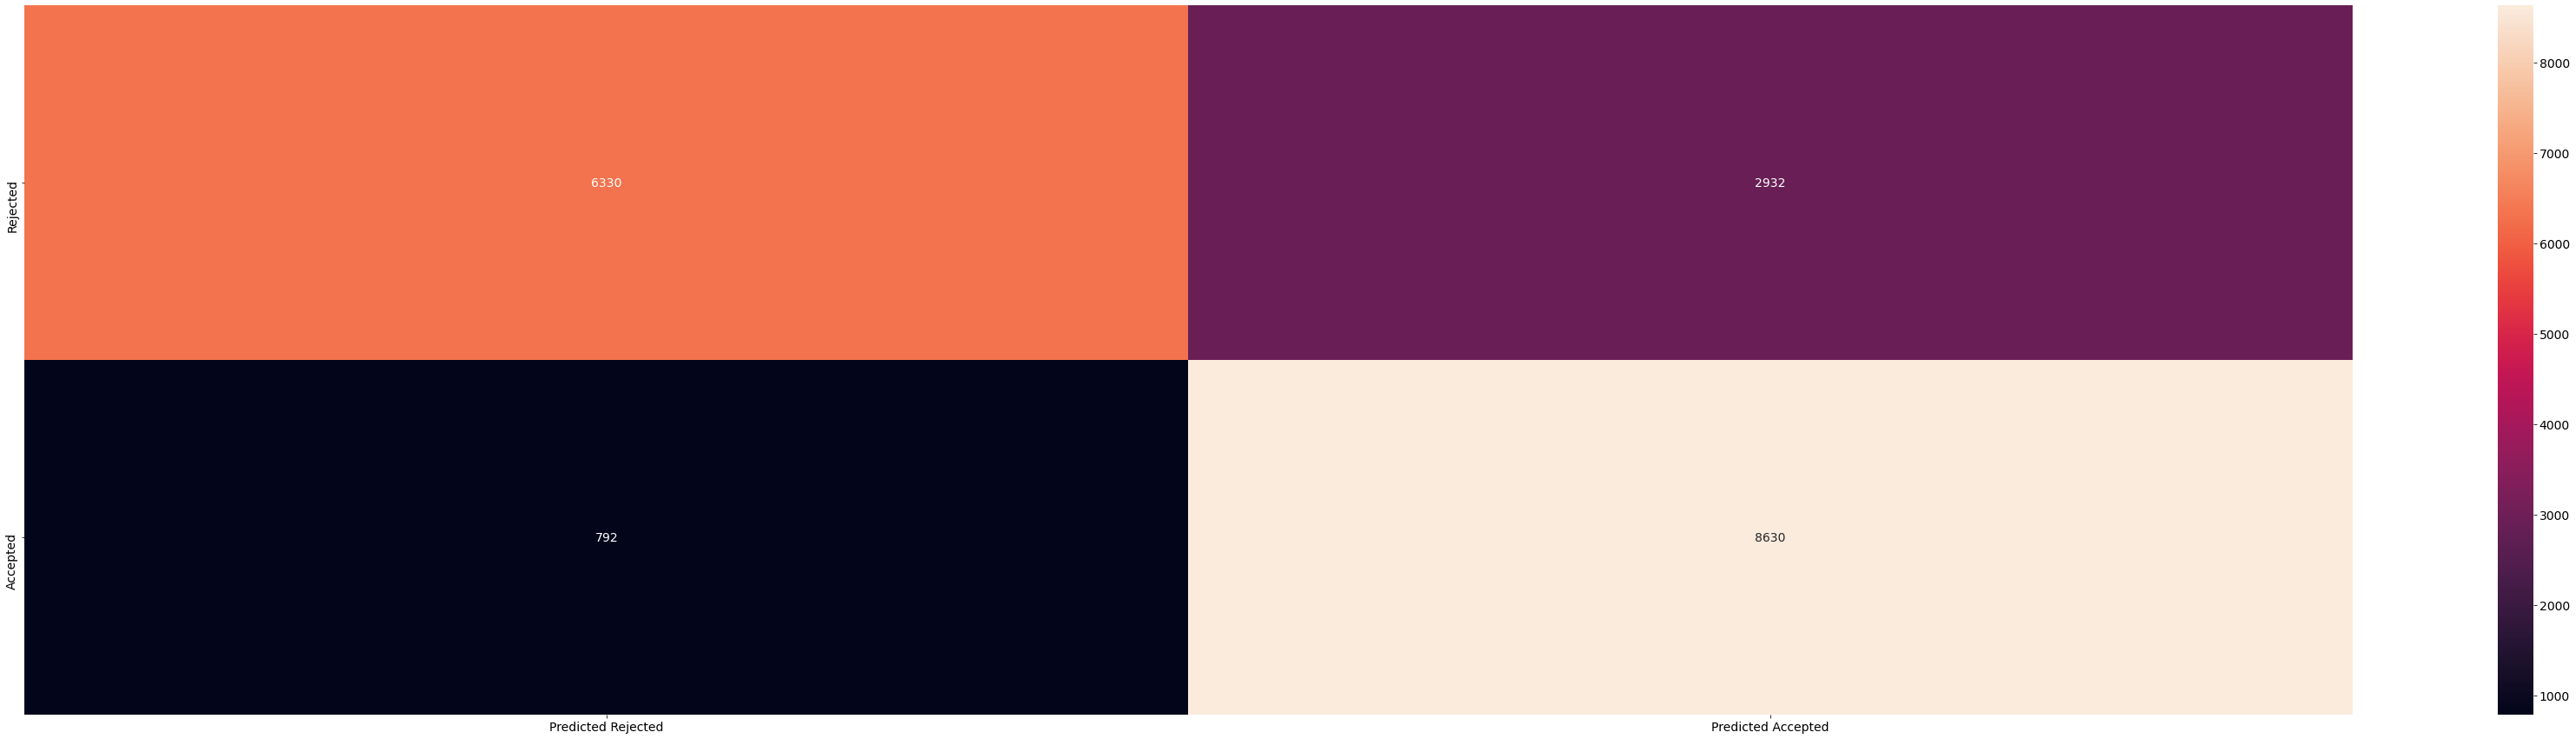

In [70]:
plot_confusion_matrix(model, ["Rejected", "Accepted"])

L'undersampling ha portato ad un risultato migliore rispetto al class weighting.

## Tecnica 3: Oversampling
Nel machine learning non si butta via nulla ! Per questo piuttosto che usare l'undersampling ci conviene sfruttare l'oversampling, che è esattamente la tecnica inversa. Piuttosto che rimuovere esempi appartenenti alla classe positiva, ne andiamo ad aggiungere, duplicando quelli esistenti, alla classe negativa, fino a pareggiare il numero di esempi negativi e positivi.

In [61]:
def oversample(df, target_column):
  
  X_pos, X_neg, y_pos, y_neg = split_data_by_label(df, target_column)
  
  ids = np.arange(len(X_pos)) # come prima, ma ora ids conterrà i possibili indici degli esempi positivi
  choices = np.random.choice(ids, len(X_neg)) # sempre come prima, ma ora campioniamo tanti indici quanti sono gli esempi negativi

  X_pos_res = X_pos[choices]
  y_pos_res = y_pos[choices]

  res_features, res_labels = concatenate(X_pos_res, X_neg, y_pos_res, y_neg)
  return res_features, res_labels

X_oversampled, y_oversampled = oversample(df, "Response")
print("Number of samples: "+str(X_oversampled.shape))
print("Labels distribution: "+str(np.unique(y_oversampled,return_counts=True)))

Number of samples: (668798, 216)
Labels distribution: (array([0, 1]), array([334399, 334399]))


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2)

In [63]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [64]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

Epoch 1/50
1881/1881 [==============================] - 11s 5ms/step - loss: 0.4522 - accuracy: 0.7811 - val_loss: 0.4249 - val_accuracy: 0.7979
Epoch 2/50
1881/1881 [==============================] - 9s 5ms/step - loss: 0.4208 - accuracy: 0.8009 - val_loss: 0.4199 - val_accuracy: 0.8007
Epoch 3/50
1881/1881 [==============================] - 9s 5ms/step - loss: 0.4167 - accuracy: 0.8028 - val_loss: 0.4175 - val_accuracy: 0.8015
Epoch 4/50
1881/1881 [==============================] - 9s 5ms/step - loss: 0.4137 - accuracy: 0.8030 - val_loss: 0.4149 - val_accuracy: 0.8025
Epoch 5/50
1881/1881 [==============================] - 9s 5ms/step - loss: 0.4115 - accuracy: 0.8041 - val_loss: 0.4128 - val_accuracy: 0.8039
Epoch 6/50
1881/1881 [==============================] - 9s 5ms/step - loss: 0.4068 - accuracy: 0.8073 - val_loss: 0.4112 - val_accuracy: 0.8044
Epoch 7/50
1881/1881 [==============================] - 9s 5ms/step - loss: 0.4055 - accuracy: 0.8079 - val_loss: 0.4095 - val_accuracy

In [65]:
model.evaluate(X_test, y_test)

4180/4180 [==============================] - 6s 2ms/step - loss: 0.3705 - accuracy: 0.8360


[0.3704829812049866, 0.8360347151756287]

Precision: 0.77
Recall: 0.95


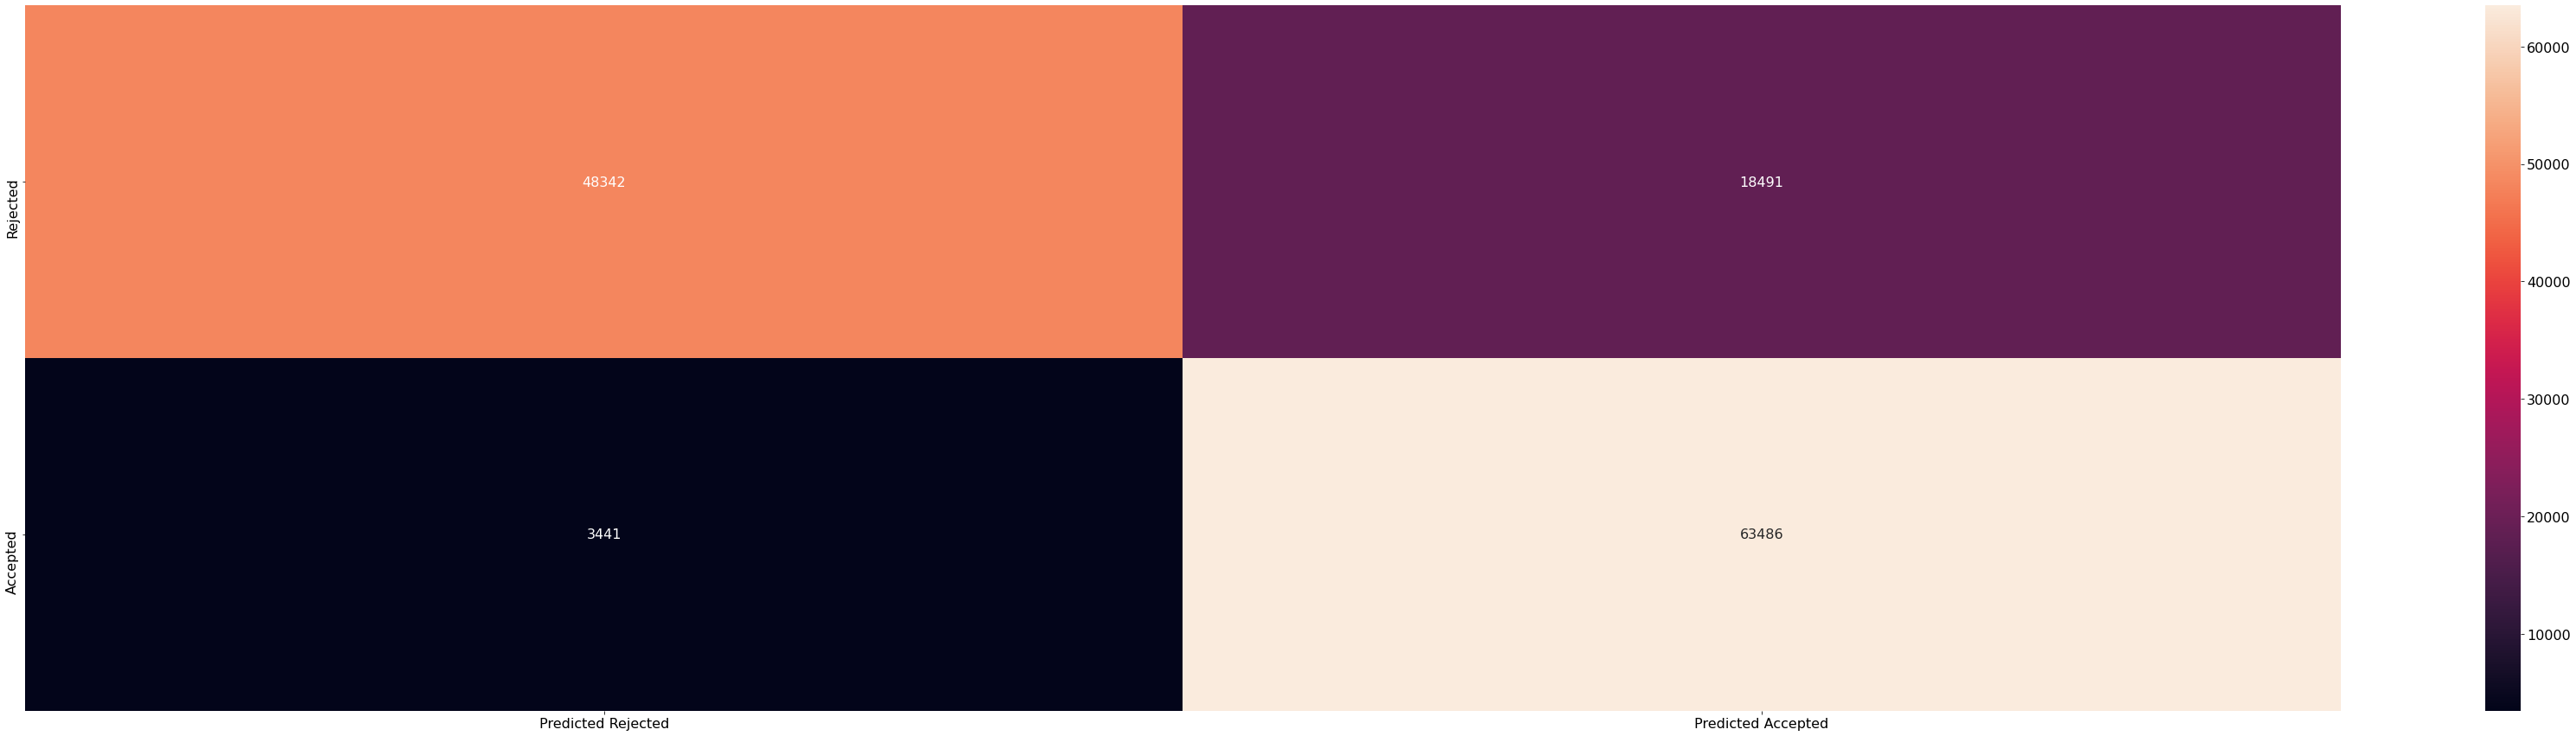

In [68]:
plot_confusion_matrix(model, ["Rejected", "Accepted"])

## Callbacks
I callbacks ci permettono di eseguire del codice durante le diverse parti della fase di addestramento. Possiamo definire dei callback nostri, possiamo utilizzare quelli messi a disposizione da tensorflow, oppure possiamo anche fare entrambe le cose. In questo esempio ti mostro due callback di tensorflow particolarmente utili, in fondo al notebook troverai la lista completa dei callback <sup>[4](#references)</sup>

In [ ]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Il primo callback che ti mostro ci permette di eseguire l'early stopping dell'addestramento.
Early Stopping è una tecnica che consiste nell'interrompere l'addestramento in maniera preventiva se il modello non sta migliorando.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                              min_delta=0.01,
                              patience=2,
                              restore_best_weights=True)

Così facendo abbiamo indicato di interrompere l'addestramento se dopo almeno patience epoche il valore della loss non è migliorato di almeno min_delta, e in tal caso di ripristinare i pesi che hanno portato al migliore risultato.

Il secondo callback è ModelCheckpoint, che ci permette di fare un backup su disco della rete neurale al termine di ogni epoca, o di un'altro intervallo temporale definito da noi.

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoint.h5", 
    save_best_only=True, # se true, salviamo solo i pesi del modello che ha ottenuto il risultato migliore
    monitor='val_loss', # quale risultato ? In questo caso la loss sul set di validazione
    #save_weights_only=True, # se true salviamo solo i pesi, e non tutto il modello 
    #save_freq='epoch'
)

ora possiamo passare un'istanza del callback all'interno del parametro callbacks del metodo fit.

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.1, callbacks=[early_stopping, model_checkpoint])

## Tensorboard

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/

In [ ]:
class TestCallback(Callback):

    def __init__(self, X_test, y_test, log_dir):
        self.X_test = X_test
        self.tesy_testt_data = y_test
        self.log_dir = log_dir
        

    def on_train_end(self, logs=None):
      loss, accuracy = self.model.evaluate(X_test, y_test)      
      
      with tf.summary.create_file_writer(self.log_dir+"/test").as_default():
        tf.summary.scalar('test_loss', data=loss, step=1)
        tf.summary.scalar('test_accuracy', data=accuracy, step=1)
     
      print("Test Loss: %.4f, Test Accuracy: %.4f" % (loss, accuracy))
      return loss, accuracy

In [ ]:
log_dir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

print(logdir)

model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, callbacks=[tensorboard_callback, TestCallback(X_test, y_test, log_dir)])

In [ ]:
%tensorboard --logdir logs/scalars

In [ ]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "Health Insurance Cross Sell Prediction" \
  --description "Predict Health Insurance Owners' who will be interested in Vehicle Insurance" \
  --one_shot

## Tuning degli Iperparametri

In [ ]:
!rm -rf ./logs/

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 8]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
METRIC_ACCURACY = 'accuracy'

In [ ]:
def tune_model(hparams):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], input_dim=X_train.shape[1], activation='relu'))
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer=hparams[HP_OPTIMIZER], metrics=['accuracy'])
  return model

In [ ]:
def run(log_dir, hparams):

    hp.hparams(hparams) 
    model = tune_model(hparams)
    
    model.fit(X_train, y_train, 
              epochs=10, batch_size=512,
              validation_split = 0.1,
              callbacks=[
                  tf.keras.callbacks.TensorBoard(log_dir),
                  hp.KerasCallback(log_dir, hparams),
                  TestCallback(X_test, y_test, log_dir)
              ],
    )

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "Health Insurance Cross Sell Prediction" \
  --description "Predict Health Insurance Owners' who will be interested in Vehicle Insurance" \
  --one_shot

## Esportare il modello

In [ ]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [ ]:
model.save("model/model.h5")

In [ ]:
from joblib import dump
dump(ss, 'model/standard_scaler.joblib')

['model/standard_scaler.joblib']

Proviamo ad importare

In [ ]:
model = load_model("model/model.h5")

In [ ]:
from joblib import load
ss = load('model/standard_scaler.joblib')

In [ ]:
# ss = ss.transform(X_test, y_test)
model.evaluate(X_test, y_test)

4180/4180 [==============================] - 6s 1ms/step - loss: 0.3841 - accuracy: 0.8258


[0.3840586543083191, 0.8257550597190857]

## Esportare il modello in modo migliore

In [ ]:
X_resampled, y_resampled = undersample(df, "Response")
# X_resampled, y_resampled = oversample(df, "Response")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

mean = X_train.mean(axis=0)
sd = X_train.std(axis=0)

In [ ]:
(X_train[0] - mean)/(sd+0.00001)

array([-1.15732177e+00, -1.95600940e-01,  3.82077505e-02, -5.97861186e-01,
        4.32437198e-01,  6.40303628e-01, -1.60984878e+00, -4.57252368e-02,
       -5.16317871e-03, -4.71715047e-02, -4.30006284e-02,  0.00000000e+00,
       -6.44237954e-02, -5.87320909e-02, -2.16356590e-02, -2.99448502e-02,
       -5.26914194e-02, -4.71715047e-02, -7.19492542e-02, -3.80317810e-02,
       -4.61638330e-02, -3.45193745e-02, -7.30606359e-03, -1.75355059e-02,
       -2.22458128e-02, -9.66842872e-03, -1.50737408e-02, -2.56038869e-02,
       -3.49056570e-02, -4.63091166e-02, -7.99671765e-02, -6.02357170e-01,
       -3.64797895e-03, -3.64797895e-03, -4.75968920e-02, -5.85022905e-02,
       -4.84365629e-02, -6.32585853e-03,  0.00000000e+00,  0.00000000e+00,
       -1.31799977e-02, -1.50737408e-02, -2.10078339e-02, -3.64797895e-03,
       -8.16965936e-03, -5.16317871e-03, -3.64797895e-03, -2.03607035e-02,
       -3.64797895e-03, -1.75355059e-02, -1.09644507e-02, -6.32585853e-03,
       -1.31799977e-02, -

In [ ]:
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)

X_train_std[0]

array([-1.15734516e+00, -1.95601077e-01,  3.82177625e-02, -5.97874760e-01,
        4.32452468e-01,  6.40317727e-01, -1.60984878e+00, -4.57352555e-02,
       -5.17315968e-03, -4.71815248e-02, -4.30106446e-02,  0.00000000e+00,
       -6.44338353e-02, -5.87421237e-02, -2.16456591e-02, -2.99548558e-02,
       -5.27014453e-02, -4.71815248e-02, -7.19593046e-02, -3.80417928e-02,
       -4.61738521e-02, -3.45293835e-02, -7.31605047e-03, -1.75455033e-02,
       -2.22558132e-02, -9.67841933e-03, -1.50837364e-02, -2.56138895e-02,
       -3.49156664e-02, -4.63191359e-02, -7.99772392e-02, -6.02370798e-01,
       -3.65795182e-03, -3.65795182e-03, -4.76069125e-02, -5.85123230e-02,
       -4.84465842e-02, -6.33584318e-03,  0.00000000e+00,  0.00000000e+00,
       -1.31899918e-02, -1.50837364e-02, -2.10178336e-02, -3.65795182e-03,
       -8.17964782e-03, -5.17315968e-03, -3.65795182e-03, -2.03707028e-02,
       -3.65795182e-03, -1.75455033e-02, -1.09744428e-02, -6.33584318e-03,
       -1.31899918e-02, -

In [ ]:
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Lambda(lambda x: (x-mean)/(sd+0.00001)))
  model.add(tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

Epoch 1/50
263/263 [==============================] - 2s 4ms/step - loss: 0.5177 - accuracy: 0.7545 - val_loss: 0.4429 - val_accuracy: 0.7877
Epoch 2/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4289 - accuracy: 0.7952 - val_loss: 0.4361 - val_accuracy: 0.7929
Epoch 3/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4279 - accuracy: 0.7954 - val_loss: 0.4344 - val_accuracy: 0.7936
Epoch 4/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4219 - accuracy: 0.7998 - val_loss: 0.4363 - val_accuracy: 0.7960
Epoch 5/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4217 - accuracy: 0.7981 - val_loss: 0.4364 - val_accuracy: 0.7931
Epoch 6/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.8007 - val_loss: 0.4360 - val_accuracy: 0.7953
Epoch 7/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4153 - accuracy: 0.8029 - val_loss: 0.4357 - val_accuracy: 0.7958
Epoch 

In [ ]:
model.save("model.h5")

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5863305502033825

<a name="references"></a>
## Bibliografia e link utili
1. [Correlation Coefficient: Simple Definition, Formula, Easy Steps](https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/)
2. [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)
3. [Precion e Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
4. [Tensorflow Callbacks Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)
 - [Tensorboard documentation](https://www.tensorflow.org/tensorboard)
 - [Hyperparameter Tuning with the HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)
 - 